In [1]:
import logging
import warnings

import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
from scipy.optimize import leastsq

In [2]:
def _gaussian_function_2d(peak_height, center_y, center_x, width_y, width_x):
    """Returns a 2D Gaussian function

    Parameters
    ----------
    peak_height :
        peak of distribution
    center_y :
        y-coordinate of distribution center
    center_x :
        x-coordinate of distribution center
    width_y :
        width of distribution along x-axis
    width_x :
        width of distribution along y-axis

    Returns
    -------
    f(x,y) : function
        Returns the value of the distribution at a
        particular x,y coordinate

    """

    return lambda y, x:  peak_height * np.exp(
        -(((center_y - y) / width_y) ** 2 + ((center_x - x) / width_x) ** 2)
        / 2
    )



def rf_guassian(dim_y, dim_x, peak_height, center_y, center_x, width_y, width_x):
    """Returns a RF matrix based on 2D Gaussian function

    Parameters
    ----------
    dim_y :
        length of y-position 
    dim_x :
        length of x-position 
    
    peak_height :
        peak of distribution
    center_y :
        y-coordinate of distribution center
    center_x :
        x-coordinate of distribution center
    width_y :
        width of distribution along x-axis
    width_x :
        width of distribution along y-axis

    Returns
    -------
    rf_matrix : RF matrix
     
    """
    f=_gaussian_function_2d(peak_height, center_y, center_x, width_y, width_x)
    rf_matrix=np.zeros((dim_y,dim_x))
    for i in range(dim_y):
        for j in range(dim_x):
            rf_matrix[i,j]=f(y=i,x=j)

    return rf_matrix





def gaussian_moments_2d(data):
    """Finds the moments of a 2D Gaussian distribution,
    given an input matrix

    Parameters
    ----------
    data : numpy.ndarray
        2D matrix

    Returns
    -------
    baseline:
        baseline of data
    peak_height :
        peak of distribution
    center_y :
        y-coordinate of distribution center
    center_x :
        x-coordinate of distribution center
    width_y :
        width of distribution along x-axis
    width_x :
        width of distribution along y-axis
    """
    
    total = data.sum()
    height = data.max()

    Y, X = np.indices(data.shape)
    center_y = (Y * data).sum() / total
    center_x = (X * data).sum() / total

    if (
        np.isnan(center_y)
        or np.isinf(center_y)
        or np.isnan(center_x)
        or np.isinf(center_x)
    ):
        return None

    col = data[:, int(center_x)]
    row = data[int(center_y), :]

    width_y = np.sqrt(
        np.abs((np.arange(row.size) - center_y) ** 2 * row).sum() / row.sum()
    )
    width_x = np.sqrt(
        np.abs((np.arange(col.size) - center_x) ** 2 * col).sum() / col.sum()
    )

    return height, center_y, center_x, width_y, width_x


def fit_2d_gaussian(matrix):
    """Fits a receptive field with a 2-dimensional Gaussian
    distribution

    Parameters
    ----------
    matrix : numpy.ndarray
        2D matrix of spike counts

    Returns
    -------
    parameters - tuple
        peak_height : peak of distribution
        center_y : y-coordinate of distribution center
        center_x : x-coordinate of distribution center
        width_y : width of distribution along x-axis
        width_x : width of distribution along y-axis
        rsq :     r-square value of fitting
    success - bool
        True if a fit was found, False otherwise
    """
    

    params = gaussian_moments_2d(abs(matrix))
    if params is None:
        return (np.nan, np.nan, np.nan, np.nan, np.nan), False

    def errorfunction(p):
        return np.ravel(
            _gaussian_function_2d(*p)(*np.indices(matrix.shape)) - matrix
        )

    fit_params, ier = leastsq(errorfunction, params)
    success = True if ier < 5 else False

    RSS=(errorfunction(fit_params)**2).sum()
    TSS=((matrix-np.mean(matrix))**2).sum()
    rsq=1-RSS/TSS
    
    return rsq, fit_params, success



def fit_2d_gaussian_stats(matrix,nShuffle=1000):
    """Compute empirical p-value of fiting a receptive field with a 2-dimensional Gaussian
    distribution

    Parameters
    ----------
    matrix : numpy.ndarray
        2D matrix of spike counts
    nShuffle: number of shuffles    

    Returns
    -------
    p_value: empirical p-value of rsq
    
    parameters - tuple
        peak_height : peak of distribution
        center_y : y-coordinate of distribution center
        center_x : x-coordinate of distribution center
        width_y : width of distribution along x-axis
        width_x : width of distribution along y-axis
        rsq :     r-square value of fitting
    success - bool
        True if a fit was found, False otherwise
    """
    
    rsq, fit_params, success = fit_2d_gaussian(matrix)
    
    length_1=len(matrix[:,0])
    length_2=len(matrix[0,:])
    
    shuffle_rsq=np.zeros(nShuffle)
    for i_shuffle in range(nShuffle):
        temp_matrix_1=matrix.reshape((length_1*length_2,1))
        temp_matrix_2=np.random.permutation(temp_matrix_1)
        temp_matrix_3=temp_matrix_2.reshape((length_1,length_2))

        temp_rsq, temp_fit_params, temp_success = fit_2d_gaussian(temp_matrix_3)
        shuffle_rsq[i_shuffle]=temp_rsq
    
    samples=len(np.argwhere(shuffle_rsq>rsq))
    p_value= (samples+1)/(nShuffle)
    
    return p_value, rsq, fit_params
    



def is_rf_inverted(rf_thresh):
    """Checks if the receptive field mapping timulus is suppressing
    or exciting the cell

    Parameters
    ----------
    rf_thresh : matrix
        matrix of spike counts at each stimulus position

    Returns
    -------
    if_rf_inverted : bool
        True if the receptive field is inverted
    """
    edge_mask = np.zeros(rf_thresh.shape)

    edge_mask[:, 0] = 1
    edge_mask[:, -1] = 1
    edge_mask[0, :] = 1
    edge_mask[-1, :] = 1

    num_edge_pixels = np.sum(rf_thresh * edge_mask)

    return num_edge_pixels > np.sum(edge_mask) / 2


def invert_rf(rf):
    """Creates an inverted version of the receptive field

    Parameters
    ----------
    rf - matrix of spike counts at each stimulus position

    Returns
    -------
    rf_inverted - new RF matrix

    """
    return np.max(rf) - rf


def threshold_rf(rf, threshold):
    """Creates a spatial mask based on the receptive field peak
    and returns the x, y coordinates of the center of mass,
    as well as the area.

    Parameters
    ----------
    rf : numpy.ndarray
        2D matrix of spike counts
    threshold : float
        Threshold as ratio of the RF's standard deviation

    Returns
    -------
    threshold_rf : numpy.ndarray
        Thresholded version of the original RF
    center_x : float
        x-coordinate of mask center of mass
    center_y : float
        y-coordinate of mask center of mass
    area : float
        area of mask
    """
    rf_filt = ndi.gaussian_filter(rf, 1)

    threshold_value = np.max(rf_filt) - np.std(rf_filt) * threshold

    rf_thresh = np.zeros(rf.shape, dtype="bool")
    rf_thresh[rf_filt > threshold_value] = True

    labels, num_features = ndi.label(rf_thresh)

    best_label = np.argmax(
        ndi.maximum(rf_filt, labels=labels, index=np.unique(labels))
    )

    labels[labels != best_label] = 0
    labels[labels > 0] = 1

    center_y, center_x = ndi.measurements.center_of_mass(labels)
    area = float(np.sum(labels))

    return labels, np.around(center_x, 4), np.around(center_y, 4), area


def rf_on_screen(rf, center_y, center_x):
    """Checks whether the receptive field is on the screen, given the
    center location."""
    return 0 < center_y < rf.shape[0] and 0 < center_x < rf.shape[1]


def convert_elevation_to_degrees(
    elevation_in_pixels, elevation_offset_degrees=-30
):
    """Converts a pixel-based elevation into degrees relative to
    center of gaze

    The receptive field computed by this class is oriented such
    that the pixel values are in the correct relative location
    when using matplotlib.pyplot.imshow(), which places (0,0)
    in the upper-left corner of the figure.

    Therefore, we need to invert the elevation value prior
    to converting to degrees.

    Parameters
    ----------
    elevation_in_pixels : float
    elevation_offset_degrees: float

    Returns
    -------
    elevation_in_degrees : float
    """
    elevation_in_degrees = (
        convert_pixels_to_degrees(8 - elevation_in_pixels)
        + elevation_offset_degrees
    )

    return elevation_in_degrees


def convert_azimuth_to_degrees(azimuth_in_pixels, azimuth_offset_degrees=10):
    """Converts a pixel-based azimuth into degrees relative
    to center of gaze

    Parameters
    ----------
    azimuth_in_pixels : float
    azimuth_offset_degrees: float

    Returns
    -------
    azimuth_in_degrees : float
    """
    azimuth_in_degrees = (
        convert_pixels_to_degrees((azimuth_in_pixels)) + azimuth_offset_degrees
    )

    return azimuth_in_degrees


def convert_pixels_to_degrees(value_in_pixels, degrees_to_pixels_ratio=10):
    """Converts a pixel-based distance into degrees

    Parameters
    ----------
    value_in_pixels : float
    degrees_to_pixels_ratio: float

    Returns
    -------
    value in degrees : float
    """
    return value_in_pixels * degrees_to_pixels_ratio


In [3]:
# Load RF data (on), select region: VISP
rf_on=np.load('BWM_rf_on.npy')
rf_off=np.load('BWM_rf_off.npy')

In [4]:
rf_on.shape

(25144, 15, 15)

In [5]:
rf_off.shape

(25144, 15, 15)

In [6]:
num_unit=len(rf_on[:,0,0])


ses_fit_params_on=np.zeros((num_unit,5))
ses_fit_params_off=np.zeros((num_unit,5))
ses_fit_params_on_off=np.zeros((num_unit,5))

ses_p_value_on=np.zeros(num_unit)
ses_p_value_off=np.zeros(num_unit)
ses_p_value_on_off=np.zeros(num_unit)

ses_r_sq_on=np.zeros(num_unit)
ses_r_sq_off=np.zeros(num_unit)
ses_r_sq_on_off=np.zeros(num_unit)


##### labels of inclulde units ######
ses_include_on=np.zeros(num_unit)
ses_include_off=np.zeros(num_unit)






for i_unit in range(num_unit):
    
    
    ses_p_value_on[i_unit]=np.nan
    ses_r_sq_on[i_unit]=np.nan
    
    ses_p_value_off[i_unit]=np.nan
    ses_r_sq_off[i_unit]=np.nan
    
    ses_p_value_on_off[i_unit]=np.nan
    ses_r_sq_on_off[i_unit]=np.nan

   
    if np.max(rf_on[i_unit,:,:])>0:
        
        
        rf_z_on= rf_on[i_unit,:,:]-np.mean(rf_on[i_unit,:,:])
        p_value, rsq, fit_params=fit_2d_gaussian_stats(rf_z_on,nShuffle=200)
        
        ses_include_on[i_unit]=1
        
        ses_p_value_on[i_unit]=p_value
        ses_r_sq_on[i_unit]=rsq
        ses_fit_params_on[i_unit,:]=fit_params
    
    if np.max(rf_off[i_unit,:,:])>0:
        
        
        rf_z_off= rf_off[i_unit,:,:]-np.mean(rf_off[i_unit,:,:])
        p_value_2, rsq_2, fit_params_2=fit_2d_gaussian_stats(rf_z_off,nShuffle=200)
        
        ses_include_off[i_unit]=1
        
        ses_p_value_off[i_unit]=p_value_2
        ses_r_sq_off[i_unit]=rsq_2
        ses_fit_params_off[i_unit,:]=fit_params_2
    
    if np.max(rf_on[i_unit,:,:])*np.max(rf_off[i_unit,:,:])>0:
        
        rf_z_on_off= rf_on[i_unit,:,:]-np.mean(rf_on[i_unit,:,:]) + rf_off[i_unit,:,:]-np.mean(rf_off[i_unit,:,:])
        p_value_3, rsq_3, fit_params_3=fit_2d_gaussian_stats(rf_z_on_off,nShuffle=200)
        
        
        ses_p_value_on_off[i_unit]=p_value_3
        ses_r_sq_on_off[i_unit]=rsq_3
        ses_fit_params_on_off[i_unit,:]=fit_params_3

/opt/anaconda3/envs/iblenv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:494: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


KeyboardInterrupt: 

In [44]:
for i_unit in range(9780,num_unit):
    
    
    ses_p_value_on[i_unit]=np.nan
    ses_r_sq_on[i_unit]=np.nan
    
    ses_p_value_off[i_unit]=np.nan
    ses_r_sq_off[i_unit]=np.nan
    
    ses_p_value_on_off[i_unit]=np.nan
    ses_r_sq_on_off[i_unit]=np.nan

   
    if np.max(rf_on[i_unit,:,:])>0:
        
        
        rf_z_on= rf_on[i_unit,:,:]-np.mean(rf_on[i_unit,:,:])
        p_value, rsq, fit_params=fit_2d_gaussian_stats(rf_z_on,nShuffle=200)
        
        ses_include_on[i_unit]=1
        
        ses_p_value_on[i_unit]=p_value
        ses_r_sq_on[i_unit]=rsq
        ses_fit_params_on[i_unit,:]=fit_params
    
    if np.max(rf_off[i_unit,:,:])>0:
        
        
        rf_z_off= rf_off[i_unit,:,:]-np.mean(rf_off[i_unit,:,:])
        p_value_2, rsq_2, fit_params_2=fit_2d_gaussian_stats(rf_z_off,nShuffle=200)
        
        ses_include_off[i_unit]=1
        
        ses_p_value_off[i_unit]=p_value_2
        ses_r_sq_off[i_unit]=rsq_2
        ses_fit_params_off[i_unit,:]=fit_params_2
    
    if np.max(rf_on[i_unit,:,:])*np.max(rf_off[i_unit,:,:])>0:
        
        rf_z_on_off= rf_on[i_unit,:,:]-np.mean(rf_on[i_unit,:,:]) + rf_off[i_unit,:,:]-np.mean(rf_off[i_unit,:,:])
        p_value_3, rsq_3, fit_params_3=fit_2d_gaussian_stats(rf_z_on_off,nShuffle=200)
        
        
        ses_p_value_on_off[i_unit]=p_value_3
        ses_r_sq_on_off[i_unit]=rsq_3
        ses_fit_params_on_off[i_unit,:]=fit_params_3

In [45]:
i_unit

25143

In [46]:
len(np.argwhere(ses_p_value_off<0.01))

813

In [47]:
len(np.argwhere(ses_p_value_on<0.01))

624

In [48]:
len(np.argwhere(ses_p_value_on_off<0.01))

1008

In [54]:
np.save('BWM_2024_rf_include_on',ses_include_on)
np.save('BWM_2024_rf_p_value_on',ses_p_value_on)
np.save('BWM_2024_rf_r_sq_on',ses_r_sq_on)
np.save('BWM_2024_rf_fit_params_on',ses_fit_params_on)


np.save('BWM_2024_rf_include_off',ses_include_off)
np.save('BWM_2024_rf_p_value_off',ses_p_value_off)
np.save('BWM_2024_rf_r_sq_off',ses_r_sq_off)
np.save('BWM_2024_rf_fit_params_off',ses_fit_params_off)


np.save('BWM_2024_rf_p_value_on_off',ses_p_value_on_off)
np.save('BWM_2024_rf_r_sq_on_off',ses_r_sq_on_off)
np.save('BWM_2024_rf_fit_params_on_off',ses_fit_params_on_off)


In [43]:
i_unit

9780

In [42]:
ses_p_value_on_off[i_unit]

nan

In [7]:
i_unit

9780

In [39]:
len(np.argwhere(ses_p_value_on[0:9780]<0.01))

245

In [40]:
len(np.argwhere(ses_p_value_off[0:9780]<0.01))

374

In [16]:
np.argwhere(ses_p_value_on[0:9780]<0.01)

array([[  24],
       [  36],
       [  42],
       [  49],
       [  59],
       [ 108],
       [ 188],
       [ 196],
       [ 262],
       [ 374],
       [ 394],
       [ 447],
       [ 458],
       [ 474],
       [ 477],
       [ 574],
       [ 577],
       [ 710],
       [ 783],
       [ 802],
       [ 812],
       [ 816],
       [ 822],
       [ 826],
       [ 878],
       [ 912],
       [1109],
       [1163],
       [1340],
       [1350],
       [1423],
       [1464],
       [1550],
       [1560],
       [1600],
       [1608],
       [1621],
       [1720],
       [1810],
       [1966],
       [1968],
       [1969],
       [1971],
       [1976],
       [1977],
       [1993],
       [2000],
       [2001],
       [2003],
       [2004],
       [2006],
       [2007],
       [2008],
       [2012],
       [2013],
       [2016],
       [2017],
       [2049],
       [2067],
       [2069],
       [2070],
       [2072],
       [2075],
       [2076],
       [2078],
       [2081],
       [20

In [25]:
np.argwhere(ses_r_sq_on[0:9780]>0.2)

array([[  42],
       [  59],
       [  86],
       [ 108],
       [ 158],
       [ 188],
       [ 193],
       [ 205],
       [ 222],
       [ 234],
       [ 270],
       [ 271],
       [ 319],
       [ 321],
       [ 371],
       [ 379],
       [ 391],
       [ 397],
       [ 409],
       [ 418],
       [ 420],
       [ 421],
       [ 438],
       [ 443],
       [ 447],
       [ 453],
       [ 455],
       [ 474],
       [ 475],
       [ 477],
       [ 485],
       [ 539],
       [ 546],
       [ 589],
       [ 662],
       [ 665],
       [ 698],
       [ 710],
       [ 716],
       [ 727],
       [ 764],
       [ 766],
       [ 788],
       [ 802],
       [ 812],
       [ 826],
       [ 867],
       [ 886],
       [ 912],
       [ 931],
       [1163],
       [1352],
       [1376],
       [1397],
       [1409],
       [1416],
       [1424],
       [1433],
       [1439],
       [1464],
       [1530],
       [1533],
       [1550],
       [1561],
       [1564],
       [1600],
       [16

In [49]:
ses_p_value_on[0:10]

array([0.465, 0.725, 0.915,   nan, 0.435, 0.965, 0.44 , 0.225, 0.455,
       0.605])

In [47]:
ses_p_value_off[0:10]

array([0.555, 0.41 , 0.23 ,   nan, 0.495, 0.33 , 0.355, 0.04 , 0.48 ,
       0.495])

In [48]:
ses_p_value_on_off[0:10]

array([0.87 , 0.375, 0.325,   nan, 0.43 , 0.145, 0.585, 0.035, 0.58 ,
       0.51 ])

In [50]:
ses_r_sq_on_off[0:10]

array([0.0134646 , 0.03382928, 0.0387174 ,        nan, 0.03579094,
       0.04778039, 0.02892227, 0.06028785, 0.02885739, 0.03209192])

In [51]:
ses_r_sq_on[0:10]

array([0.03293209, 0.02128998, 0.01059853,        nan, 0.03419627,
       0.        , 0.03401583, 0.04351821, 0.03111298, 0.02255023])

In [52]:
ses_r_sq_off[0:10]

array([0.0244704 , 0.03645846, 0.04797931,        nan, 0.03200108,
       0.03630705, 0.0391121 , 0.09151248, 0.03318659, 0.03059711])

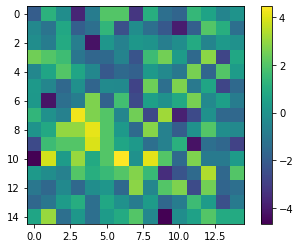

In [41]:
######## Compute z-scroe of RF:
unit_e=9714
rf_z= rf_on[unit_e,:,:]-np.mean(rf_on[unit_e,:,:])


####### plot RF ##########
plt.imshow(rf_z)
plt.colorbar()

In [35]:
np.max(rf_on[3,:,:])

0.0

In [39]:
        rf_z_on= rf_on[5,:,:]-np.mean(rf_on[5,:,:])
        p_value, rsq, fit_params=fit_2d_gaussian_stats(rf_z_on,nShuffle=100)

In [41]:
p_value

0.97

In [42]:
rsq

0.0

In [43]:
fit_params

array([-0.41610457, 10.26212298, -1.88909828, 11.03393709,  0.23958469])

In [57]:
ses_fit_params_on_off[5,:]

array([75.97618486,  8.04435575,  3.53045521,  0.56983369,  0.25038169])